Логистическая регрессия

И в линейной и в логистической регрессии используется линейная функция. Только в линейной регрессии она используется для предсказания значений, а в логистической - для предсказания отнесения к одному из двух классов (0 или 1, да или нет, и т.д.)

Классы разделяются поверхностью, в зависимости от кол-ва фичей это может быть линия, плоскость или гиперплоскость (многомерная плоскость)

Чем дальше значения лежат от разделяющей поверхности, тем уверенее модель относит объект к тому или иному классу. Но по абсолютным значениям нельзя сказать, насколько мы далеко от некой точки. Поэтому абсолютные числа надо перевести в относительные. Сделать это можно прогоняя числа через функцию сигмоиды. В результате получим числа в диапазоне от 0 до 1.

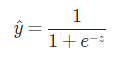

z - ответы линейной функции

Чем больше значение логита, тем дальше оно будет от разделяющей линии и тем ближе значение будет к 1 после применения функции сигмоиды (т.е. тем выше уверенность). Отрицательные значения будут меньше 0.5 – это значит, что они принадлежат другому классу. Чем ближе логиты к разделяющей плоскости, тем ближе будут значение к 0.5 после применения сигмоиды – т.е. модель меньше будет уверена в ответе.


В некоторых библиотеках машинного обучения значения, полученные после сигмоиды, называются predict_proba.

LogLoss

LogLoss - функция потерь логистической регрессии

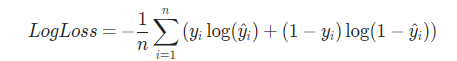

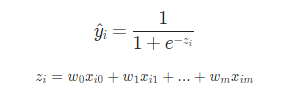

Выражая в матричном виде, получим

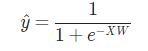

Градиент по функции потерь:

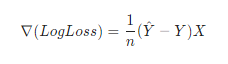

Переходим к практике

In [26]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from sklearn.metrics import  roc_curve

X, y = make_classification(n_samples=1000, n_features=14, n_informative=10, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
class MyLogReg():
    def __init__(self, n_iter=10, learning_rate=0.1, weights=None):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights

    def predict_proba(self, X):
        X = X.copy()
        X.insert(0, "bias", 1)
        return 1 / (1 + np.exp(-X @ self.weights))
    
    def predict(self, X):
        X = X.copy()
        X.insert(0, "bias", 1)
        return np.where((1 / (1 + np.exp(-X @ self.weights))) > 0.5, 1, 0)
    
    def fit(self, X, y, verbose=False):
        X = X.copy()
        y = y.copy()
        X.insert(0, "bias", 1)
        if self.weights is None:    
            self.weights = np.ones(X.shape[1])

        error_hist = []

        for epoch in range(self.n_iter):
            y_pred = 1 / (1 + np.exp(-X @ self.weights))
            self.weights -= self.learning_rate * self.get_grad(X, y, y_pred)

            log_loss = self.get_log_loss(y, y_pred)
            error_hist.append(log_loss)

            if verbose and (epoch == 1) | (epoch % verbose == 0):
                print(f'{epoch}| LogLoss: {np.round(log_loss, 2)}')    
        return error_hist     

    def get_grad(self, X, y, y_pred):
        return ((y_pred - y) @ X) / len(y_pred)

    def get_log_loss(self, y, y_pred):
        return -np.mean((y * np.log(y_pred + 1e-15)) + (1 - y) * np.log(1 - y_pred + 1e-15))
    
    def __str__(self) -> str:
        return f"{self.__class__.__name__} class: " + ", ".join("%s=%s" % item for item in vars(self).items())
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__} class: " + ", ".join("%s=%s" % item for item in vars(self).items())
    
    def get_coef(self):
        return self.weights[1:]

0| LogLoss: 3.83
1| LogLoss: 3.53
10| LogLoss: 1.78
20| LogLoss: 1.14
30| LogLoss: 0.82
40| LogLoss: 0.65
50| LogLoss: 0.56
60| LogLoss: 0.51
70| LogLoss: 0.47
80| LogLoss: 0.45
90| LogLoss: 0.43
100| LogLoss: 0.42
110| LogLoss: 0.41
120| LogLoss: 0.4
130| LogLoss: 0.39
140| LogLoss: 0.39


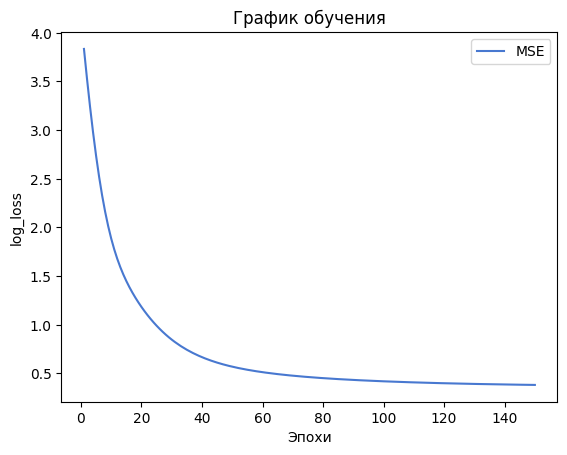

In [28]:
logreg = MyLogReg(n_iter=150, learning_rate=0.1)
history = logreg.fit(X_train, y_train, 10)

epochs = range(1, len(history) + 1)

plt.plot(epochs, history, 'b', label='MSE')
plt.title('График обучения')
plt.xlabel('Эпохи')
plt.ylabel('log_loss')
plt.legend()

# Отобразите график.
plt.show()

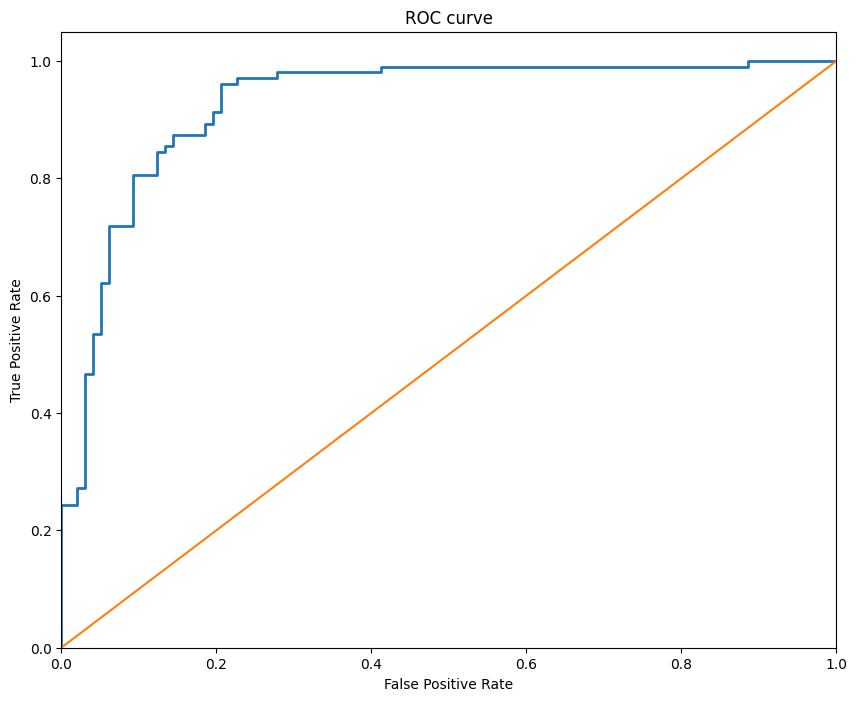

In [29]:
import seaborn as sns
sns.set_color_codes("muted")


plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test), pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [30]:
pred = logreg.predict(X_test)
print('accuracy: ', (pred == y_test).sum() / len(y_test))

accuracy:  0.85


In [31]:
metric_dict = {'roc_auc': skm.roc_auc_score(y_test, logreg.predict_proba(X_test)),
                'precision': skm.precision_score(y_test, pred),
                'recall': skm.recall_score(y_test, pred),
                'f1': skm.f1_score(y_test, pred)}
for k, v in metric_dict.items():
    print(f"{k}: {v}")

roc_auc: 0.9281353217896107
precision: 0.8348623853211009
recall: 0.883495145631068
f1: 0.8584905660377359
